In [226]:
import pandas as pd
import torch
import torchaudio
import tensorflow as tf
import tensorflow_hub as hub
from b2aiprep.process import Audio, plot_waveform
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [227]:
# active_slot_duration = 5 # in sec
# need_complete_audio = True
filter_label = "RP" # FIMO, RP, Deep, or empty
label_column = 'phonatory_status'  # Or 'stridor_status', 'status', 'phonatory_status', depending on your use case
# audio_sample_duration = active_slot_duration

# slider information
is_sliding_window_travel = True
traversal_window_frame = 5 # in sec
traversal_rate = 1 # in sec

model_name = f"YAM_{traversal_window_frame}_{traversal_rate}_{filter_label}_{label_column}"
print(model_name)

YAM_5_1_RP_phonatory_status


In [228]:
from lib import generate_recording_objects, count_samples, filter_recordings_by_label, get_most_active_segment

In [229]:
# Usage
root_path = 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files'  # Replace with the actual path to your folders
excel_path = 'C:\\Users\\namac\\Studies\\B2AI\\Stridor_Labels.xlsx'  # Replace with the actual path to your Excel file
output_csv = 'rec_6_time.csv'  # Desired output CSV file name
output_json = 'rec_6_time.json'  # Desired output JSON file name

# Read the Excel file
patient_status_df = pd.read_excel(excel_path)

recordings = generate_recording_objects(root_path, patient_status_df, label_column)
print(f"Total samples: {len(recordings)}")

# Uncomment the following lines to save to CSV
# save_to_csv(recordings, output_csv)
# print(f"Recording objects have been saved to {output_csv}")

# Uncomment the following lines to save to JSON
# save_to_json(recordings, output_json)
# print(f"Recording objects have been saved to {output_json}")

# Count the samples
no_stridor_count, phonatory_count, non_phonatory_count = count_samples(recordings)
print(f"No-Stridor samples: {no_stridor_count}")
print(f"Phonatory samples: {phonatory_count}")
print(f"Non-Phonatory samples: {non_phonatory_count}")

Total samples: 620
No-Stridor samples: 270
Phonatory samples: 89
Non-Phonatory samples: 261


In [230]:
data = recordings.copy()
print(f"data count: {len(data)}")

# Filter recordings
if (len(filter_label)):
    filtered_data = filter_recordings_by_label(data, filter_label)
    data = filtered_data


print(f"filtered recordings count: {len(data)}")
# print(f"filtered recordings: {data}")

data count: 620
filtered recordings count: 95


In [231]:
# Prepare audio dataset
audio_data = []
for entry in data:
    # Calculate the traversal sliding slots
    # if there is any last block left, just reverse this and create extra slot

    row = entry.copy()
    travel_reminder = int(entry["duration"] % traversal_rate)
    
    audio_duration = entry["duration"]
    sr = 16000  # Assuming the sample rate is 16 kHz after resampling
    traversal_window_samples = traversal_window_frame * sr
    traversal_rate_samples = traversal_rate * sr
    
    # Load the full audio signal
    audio = Audio.from_file(entry["recording"]).to_16khz()
    y = audio.signal.squeeze(1)  # Ensure the tensor has the correct dimensions
    
    segments = []
    for start in range(0, len(y), traversal_rate_samples):
        end = start + traversal_window_samples
        if end <= len(y):
            segments.append(y[start:end])
        else:
            # Handle remaining audio at the end if any
            remaining_audio = y[-traversal_window_samples:]
            segments.append(remaining_audio)
            break
    
    for i, segment in enumerate(segments):
        if segment.shape[0] < traversal_window_samples:
            padding_needed = traversal_window_samples - segment.shape[0]
            segment = torch.nn.functional.pad(segment, (0, padding_needed))
        
        segment_audio = Audio(segment.unsqueeze(1), audio.sample_rate)
        segment_row = row.copy()
        segment_row["uid"] = f"{entry['uid']}-{i+1}"
        segment_row["duration"] = traversal_window_frame
        segment_row["audio_sample"] = segment_audio
        audio_data.append(segment_row)

UID: 74f76aad-418d-4e25-8c67-6857b0473fda-5
Recording ID: 74f76aad-418d-4e25-8c67-6857b0473fda
Recording Label: RP12inch


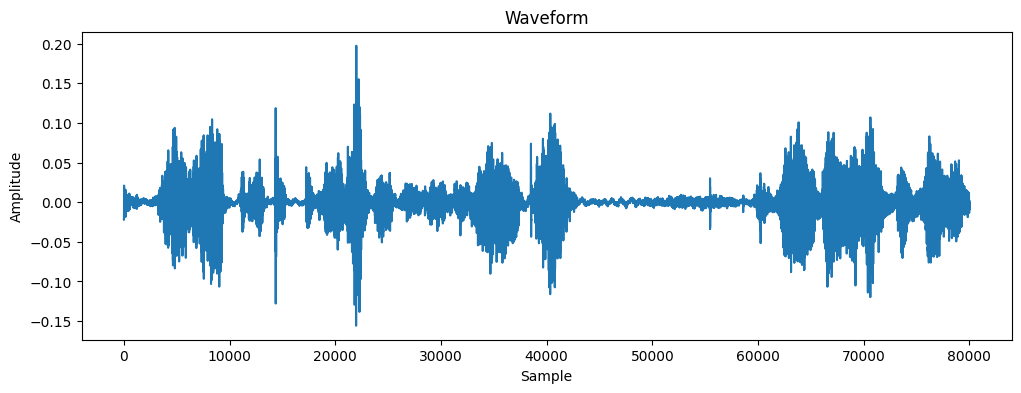

In [232]:
from lib import display_and_play_sample
index = 4  # Replace with the desired sample index
display_and_play_sample(audio_data, index)

In [233]:
# Load YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [234]:
def extract_yamnet_embeddings(audio_tensor, sample_rate=16000):
    waveform = audio_tensor.squeeze().numpy()  # Remove the extra dimension if present
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    embeddings = yamnet_model(waveform)[1]
    return embeddings.numpy()  # Ensure embeddings are in numpy format

In [247]:
class MyYamnetDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_column, num_classes):
        self.dataframe = dataframe.copy()  # Copy to avoid modifying the original DataFrame
        self.label_column = label_column
        self.num_classes = num_classes
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording_id', 'name', 'recording_label', 'recording', 'audio_sample', label_column]
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")
            
        # Store the unique labels and create a mapping
        self.unique_labels = list(self.dataframe[label_column].unique())
        self.label_to_index = {label: index for index, label in enumerate(self.unique_labels)}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}

        # Convert the label column to integer indices
        self.dataframe[label_column] = self.dataframe[label_column].map(self.label_to_index)

        # Extract necessary information from the DataFrame
        self.audio_samples = dataframe['audio_sample'].tolist()
        self.labels = self.dataframe[label_column].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()
        self.recording_ids = dataframe['recording_id'].tolist()
        self.names = dataframe['name'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_sample = self.audio_samples[idx]
        label = self.labels[idx]
        name = self.names[idx]
        recording_label = self.recording_labels[idx]
        
        # Ensure audio_sample is an instance of Audio
        if not isinstance(audio_sample, Audio):
            raise ValueError(f"Expected audio_sample to be an instance of Audio, but got {type(audio_sample)}")

        # Access the signal and sample_rate attributes
        audio_signal = audio_sample.signal
        sample_rate = audio_sample.sample_rate

        # Extract YAMNet embeddings
        embeddings = extract_yamnet_embeddings(audio_signal)
        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        
        print(f"label: {label}")

        # Convert the label to a one-hot encoded tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        label_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=self.num_classes).float()
        
        print(f"label_tensor: {label_tensor}")
        print(f"self.label_column: {self.label_column}")

        return {'uid': uid, 'embeddings': embeddings, 'audio': audio_signal, self.label_column: label_tensor, 'recording_label': recording_label}

    def decode_label(self, label_tensor):
        if label_tensor.dim() == 1 and label_tensor.size(0) == self.num_classes:
            label_index = torch.argmax(label_tensor).item()
        elif label_tensor.dim() == 0:
            label_index = label_tensor.item()
        else:
            raise ValueError("Unsupported label tensor format")
        
        return self.index_to_label[label_index]

In [248]:
# Convert audio data to DataFrame and create dataset
df = pd.DataFrame(audio_data)
num_classes = df[label_column].nunique()
dataset = MyYamnetDataset(df, label_column, num_classes)

label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 1
label_tensor: tensor([0., 1.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
label: 0
label_tensor: tensor([1., 0.])
self.label_column: phonatory_status
torch.Size([8, 10, 1024])
['RPavid', 'RPiPad', 'RPAvid', 'RPiPad', 'RP12in&3in', 'RPAvid', 'RPiPad', 'RPAvid'] tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


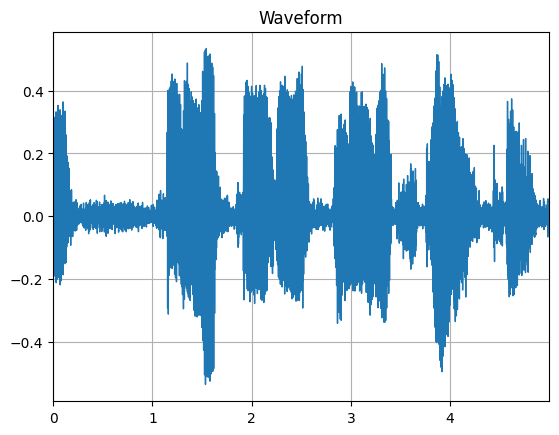

In [249]:
# Split the dataset and create DataLoaders
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch["embeddings"].size())
    print(batch['recording_label'], batch[label_column])
    plot_waveform(batch['audio'][0], 16000, title="Waveform", ax=None)
    break

In [238]:
# class Classifier(torch.nn.Module):
#     def __init__(self, num_classes):
#         super(Classifier, self).__init__()
#         self.fc = torch.nn.Linear(10240, num_classes)  # 1024 is the embedding size, num_classes is the number of output classes
    
#     def forward(self, x):
#         if len(x.shape) > 2:
#             x = x.view(x.size(0), -1)  # Flatten the embeddings if necessary
#         x = self.fc(x)
#         return x

# Define a CNN classifier on top of YAMNet embeddings
from torch import nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.dropout = nn.Dropout(0.5)
        
        # Calculate the size of the flattened feature map after the conv and pooling layers
        self._to_linear = None
        self.convs(torch.randn(1, 1, 10, 1024))  # Forward pass to calculate the size
        
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
    
    def convs(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, 10, 1024]
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_classifier = CNNClassifier(num_classes).to(device)

In [240]:
# Evaluation and confusion matrix
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            embeddings = batch['embeddings'].to(device)

            # Reshape embeddings to fit CNN input requirements
            embeddings = embeddings.view(embeddings.size(0), 10, 1024)

            outputs = model(embeddings)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = torch.argmax(batch[label_column], dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_preds, all_labels

# Training loop
num_epochs = 20
optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=0.0001, weight_decay=5e-5)
best_val_acc = 0

def eval_cnn_classifier(model, dataloader, device):
    model.eval()
    acc = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            embeddings = batch['embeddings'].to(device)
            labels = batch[label_column].to(device)

            # Reshape embeddings to fit CNN input requirements
            embeddings = embeddings.view(embeddings.size(0), 10, 1024)

            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)  # Ensure labels are not one-hot encoded
            
            acc += (predicted == true_labels).sum().item()
            total += labels.size(0)

    return acc / total

In [241]:
for epoch in range(num_epochs):
    cnn_classifier.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()

        embeddings = batch['embeddings'].to(device)
        labels = batch[label_column].to(device)

        # Reshape embeddings to fit CNN input requirements
        embeddings = embeddings.view(embeddings.size(0), 10, 1024)

        outputs = cnn_classifier(embeddings)

        # Ensure labels are not one-hot encoded
        _, true_labels = torch.max(labels, 1)  # Convert one-hot encoded to integer labels
        assert outputs.shape == (embeddings.shape[0], num_classes), f"Expected outputs shape: ({embeddings.shape[0]}, {num_classes}), got: {outputs.shape}"
        assert true_labels.shape == (embeddings.shape[0],), f"Expected true_labels shape: ({embeddings.shape[0]},), got: {true_labels.shape}"
        
        # Compute loss
        loss = torch.nn.functional.cross_entropy(outputs, true_labels)  # Cross-entropy expects class indices
        
        closs.append(loss.item())
        loss.backward()
        optimizer.step()

    train_acc = eval_cnn_classifier(cnn_classifier, train_dataloader, device)
    val_acc = eval_cnn_classifier(cnn_classifier, val_dataloader, device)
    print(f'Epoch: {epoch+1} TrainLoss: {sum(closs)/len(closs):.4f} TrainACC: {train_acc:.4f} ValACC: {val_acc:.4f}')

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn_classifier.state_dict(), f'./save/{model_name}.pth')
        print('Saved!')


Epoch: 1 TrainLoss: 0.5403 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 2 TrainLoss: 0.4556 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 3 TrainLoss: 0.4187 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 4 TrainLoss: 0.3784 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 5 TrainLoss: 0.3404 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 6 TrainLoss: 0.3166 TrainACC: 0.8133 ValACC: 0.8248
Saved!
Epoch: 7 TrainLoss: 0.2890 TrainACC: 0.9142 ValACC: 0.8854
Saved!
Epoch: 8 TrainLoss: 0.2739 TrainACC: 0.9007 ValACC: 0.8631
Epoch: 9 TrainLoss: 0.2498 TrainACC: 0.9345 ValACC: 0.9045
Saved!
Epoch: 10 TrainLoss: 0.2374 TrainACC: 0.8769 ValACC: 0.8535
Epoch: 11 TrainLoss: 0.2153 TrainACC: 0.9273 ValACC: 0.8758
Epoch: 12 TrainLoss: 0.2055 TrainACC: 0.9607 ValACC: 0.8885
Epoch: 13 TrainLoss: 0.1746 TrainACC: 0.9706 ValACC: 0.8822
Epoch: 14 TrainLoss: 0.1639 TrainACC: 0.9877 ValACC: 0.9076
Saved!
Epoch: 15 TrainLoss: 0.1544 TrainACC: 0.9913 ValACC: 0.9108
Saved!
Epoch: 16 TrainLoss: 0.1436 TrainACC: 0

In [242]:
# def eval_classifier(model, dataloader, device):
#     model.eval()
#     acc = 0
#     total = 0
#     with torch.no_grad():
#         for batch in dataloader:
#             embeddings = batch['embeddings'].to(device)
#             labels = batch[label_column].to(device)

#             # Flatten the embeddings to remove the extra dimension
#             embeddings = embeddings.view(embeddings.size(0), -1)

#             outputs = model(embeddings)
#             _, predicted = torch.max(outputs, 1)
#             _, true_labels = torch.max(labels, 1)  # Ensure labels are not one-hot encoded
            
#             acc += (predicted == true_labels).sum().item()
#             total += labels.size(0)

#     return acc / total

# num_epochs = 20
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, weight_decay=5e-5)
# best_val_acc = 0

# for epoch in range(num_epochs):
#     classifier.train()
#     closs = []
#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         embeddings = batch['embeddings'].to(device)
#         labels = batch[label_column].to(device)

#         # Flatten the embeddings to remove the extra dimension
#         embeddings = embeddings.view(embeddings.size(0), -1)

#         outputs = classifier(embeddings)

#         # Ensure labels are not one-hot encoded
#         _, true_labels = torch.max(labels, 1)  # Convert one-hot encoded to integer labels
#         assert outputs.shape == (embeddings.shape[0], num_classes), f"Expected outputs shape: ({embeddings.shape[0]}, {num_classes}), got: {outputs.shape}"
#         assert true_labels.shape == (embeddings.shape[0],), f"Expected true_labels shape: ({embeddings.shape[0]},), got: {true_labels.shape}"
        
#         # Compute loss
#         loss = torch.nn.functional.cross_entropy(outputs, true_labels)  # Cross-entropy expects class indices
        
#         closs.append(loss.item())
#         loss.backward()
#         optimizer.step()

#     train_acc = eval_classifier(classifier, train_dataloader, device)
#     val_acc = eval_classifier(classifier, val_dataloader, device)
#     print(f'Epoch: {epoch+1} TrainLoss: {sum(closs)/len(closs):.4f} TrainACC: {train_acc:.4f} ValACC: {val_acc:.4f}')

#     if val_acc >= best_val_acc:
#         best_val_acc = val_acc
#         torch.save(classifier.state_dict(), f'./save/{model_name}.pth')
#         print('Saved!')

In [243]:
print(model_name)

YAM_5_1_RP_phonatory_status


['Non-Phonatory', 'Phonatory']


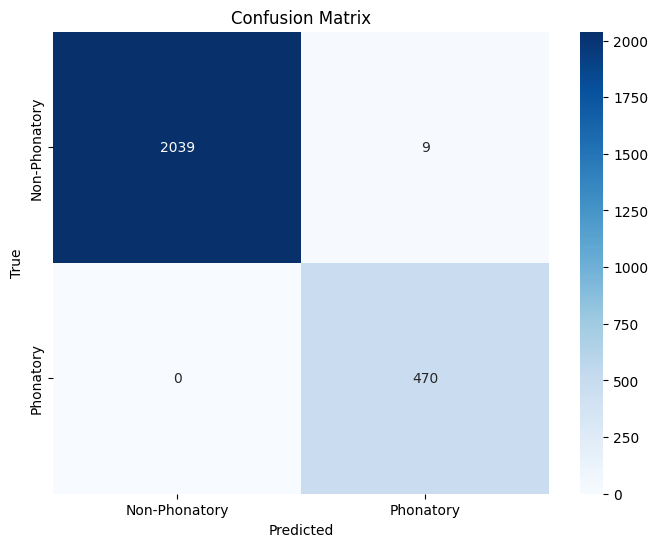

Classification Report:
                precision    recall  f1-score   support

Non-Phonatory     1.0000    0.9956    0.9978      2048
    Phonatory     0.9812    1.0000    0.9905       470

     accuracy                         0.9964      2518
    macro avg     0.9906    0.9978    0.9942      2518
 weighted avg     0.9965    0.9964    0.9964      2518



In [246]:
# Load the best model
cnn_classifier.load_state_dict(torch.load(f'./save/{model_name}.pth'))

# Get predictions and true labels for the test set
preds, labels = get_predictions_and_labels(cnn_classifier, train_dataloader, device)
# preds, labels = get_predictions_and_labels(cnn_classifier, test_dataloader, device)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(labels, preds)
print(dataset.unique_labels)
class_report = classification_report(labels, preds, target_names=dataset.unique_labels, digits=4)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.unique_labels, yticklabels=dataset.unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:\n', class_report)